# 0 Import data

In [1]:
import pandas as pd
train = pd.read_csv('liar_dataset/train.tsv', sep='\t')
train.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'spkrJobTitle', 'state', 'party', 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'context']

test = pd.read_csv('liar_dataset/test.tsv', sep='\t')
test.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'spkrJobTitle', 'state', 'party', 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'context']

# Column 1: the ID of the statement ([ID].json).
# Column 2: the label.
# Column 3: the statement.
# Column 4: the subject(s).
# Column 5: the speaker.
# Column 6: the speaker's job title.
# Column 7: the state info.
# Column 8: the party affiliation.
# Column 9-13: the total credit history count, including the current statement.
# 9: barely true counts.
# 10: false counts.
# 11: half true counts.
# 12: mostly true counts.
# 13: pants on fire counts.
# Column 14: the context (venue / location of the speech or statement).

In [2]:
from typing import List
import numpy as np

# 1 Conduct Exploratory Data Analysis

## 1.1 Check dataframe info (Non-Nulls, Counts, Data types)

In [3]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 10239 non-null  object 
 1   label              10239 non-null  object 
 2   statement          10239 non-null  object 
 3   subject            10237 non-null  object 
 4   speaker            10237 non-null  object 
 5   spkrJobTitle       7342 non-null   object 
 6   state              8031 non-null   object 
 7   party              10237 non-null  object 
 8   barelyTrueCounts   10237 non-null  float64
 9   falseCounts        10237 non-null  float64
 10  halfTrueCounts     10237 non-null  float64
 11  mostlyTrueCounts   10237 non-null  float64
 12  pantsOnFireCounts  10237 non-null  float64
 13  context            10137 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 12

## 1.2 Check Nulls and Nans

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def PlotMissingData(df, dataName:str):
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isna().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})
    figName = 'missingData' + dataName + '.png'
    plt.savefig(figName, dpi=100)
    plt.title(figName, fontsize =20)
    plt.show()

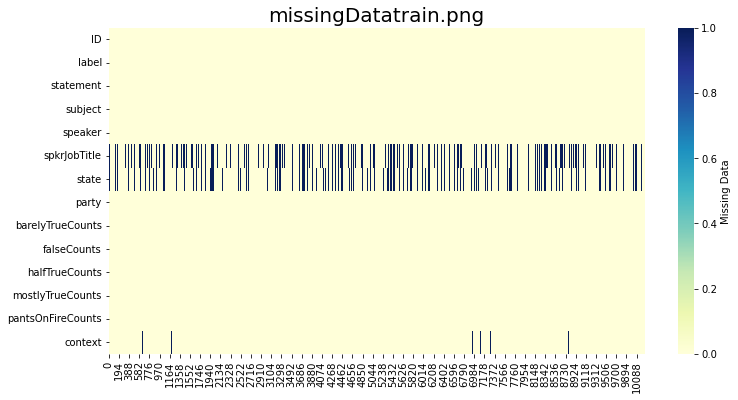

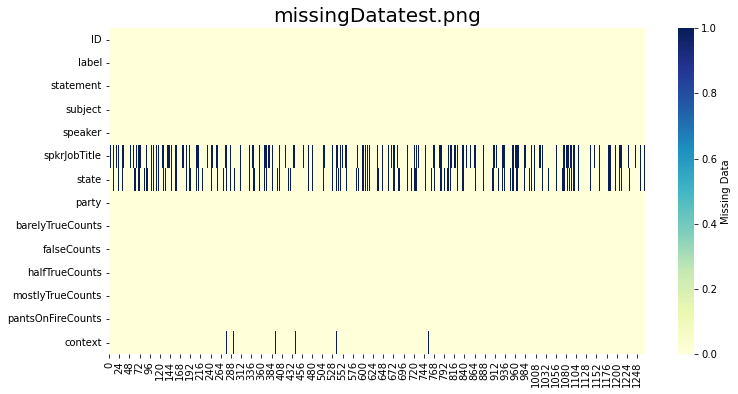

In [5]:
PlotMissingData(train, 'train')
PlotMissingData(test, 'test')

In [6]:
# (percent missing nulls, absolute count of nulls)
trainMissing = (train.isnull().sum() / train.shape[0] * 100, train.isnull().sum())
testMissing = (test.isnull().sum() / test.shape[0] * 100, train.isnull().sum())

print(trainMissing[1])
print(testMissing[1])

ID                      0
label                   0
statement               0
subject                 2
speaker                 2
spkrJobTitle         2897
state                2208
party                   2
barelyTrueCounts        2
falseCounts             2
halfTrueCounts          2
mostlyTrueCounts        2
pantsOnFireCounts       2
context               102
dtype: int64
ID                      0
label                   0
statement               0
subject                 2
speaker                 2
spkrJobTitle         2897
state                2208
party                   2
barelyTrueCounts        2
falseCounts             2
halfTrueCounts          2
mostlyTrueCounts        2
pantsOnFireCounts       2
context               102
dtype: int64


## 1.3 Check duplicates

In [7]:
def CheckDuplicateIDs(df):
    duplicateIDs = []
    for count in df.ID.value_counts():
        if count > 1:
            duplicateIDs.append(df.ID)
    if duplicateIDs:
        return duplicateIDs
    else:
        return 'No duplicate IDs'

duplicateTrainIDs = CheckDuplicateIDs(train)
duplicateTestIDs = CheckDuplicateIDs(test)
print(duplicateTrainIDs, duplicateTestIDs)


No duplicate IDs No duplicate IDs


## 1.4 Check Quantitative


(array([2114.,    0., 1962.,    0., 1994.,    0., 1676.,    0., 1654.,
         839.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

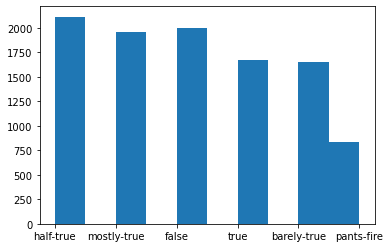

In [8]:
plt.hist(train['label']) 

# Observation:
# Pants-fire has 750 counts vs. the other classes which have approx 1500-2000 counts.

# 2 Preprocess 

## 2.1 Get Unique List of Subjects, Contexts, Speakers

In [9]:
subjects = train['subject'].unique() # Not unique yet because each item is a comma delimited string
contexts = train['context'].unique()
speakers = train['speaker'].unique() 

In [10]:
def GetUniqueSubjects(subjects) -> set:
    allSubjects = []
    for subject in subjects:
        try:
            _subjects = subject.split(',')
            for item in _subjects:
                allSubjects.append(item)
        except:
            continue

    return set(allSubjects)

In [11]:
uniqueSubjects = GetUniqueSubjects(subjects)

## 2.2 Process each statement

In [12]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
def RemovePunctuation(sentence: str, punctuations: str) -> str:
    noPunctuation = ""
    for char in sentence:
        if char not in punctuations:
            noPunctuation = noPunctuation + char
    return noPunctuation

In [14]:
def ProcessStatement(statements: List[str], punctuations: str, cachedStopWords: List, snowballStemmer: SnowballStemmer) -> List[str]:

    processedStatements = []
    for statement in statements:
        # Make lower case
        _statement = statement.lower()

        # Remove punctuation
        _statement = RemovePunctuation(_statement, punctuations)
        
        # Remove numbers
        _statement  = re.sub('\w*\d\w*', '', _statement) 

        # Split/Tokenise
        _statement = _statement.split(' ') 

        _wordlist = []
        for word in _statement:
            # Exclude stop word. Exclude one-letter words
            if not word in cachedStopWords and len(word) > 1:
                # Stem the word
                _wordlist.append(snowballStemmer.stem(word))
        processedStatements.append(_wordlist)
    
    return processedStatements

In [15]:
cachedStopWords = stopwords.words("english")
statements = list(train['statement'])
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
snowballStemmer = SnowballStemmer('english')

processedStatements = ProcessStatement(statements, punctuations, cachedStopWords, snowballStemmer)

In [16]:
train['processedStatements'] = processedStatements

## 2.3 Vectorise

In [17]:
import gensim

# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin'

# 3 Train

IndexError: tuple index out of range